#### Directories etc

In [22]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode
from scipy.stats import chi2

In [2]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [4]:
max_len = 0
orfs_found = []
start_pos = -999
end_pos = -999
orf_length_counts = [0 for x in full_sequence]

for frame in ['Forward', 'Reverse']:
    if frame == 'Forward':
        temp = full_sequence
    else:
        temp = util.reverse_complement(full_sequence)
    seq_len = len(temp)
    for i in tqdm(range(seq_len - 2)):
        orf_length = 0
        test_codon = temp[i: i+3] 
        if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
            for j in range(i + 3, seq_len - 2, 3):
                test_codon_2 = temp[j: j+3] 
                if test_codon_2 in ['TAG','TGA','TAA']:
                    orf_length = j - i
                    break
            if orf_length > 0:
                if frame == 'Forward':
                    orf_start =  i
                    orf_end = j+3
                    orf_strand = 1
                else:
                    orf_start =  seq_len-(j+3)
                    orf_end =  seq_len-i
                    orf_strand = -1
                for i in range(orf_start, orf_end):
                    orf_length_counts[i] = max(orf_length, orf_length_counts[i])

100%|██████████| 4411530/4411530 [00:19<00:00, 222637.68it/s]


In [5]:
orf_length_averages = []
seq_end = len(orf_length_counts)
for n,i in tqdm(enumerate(orf_length_counts)):
    start_pos = n
    end_pos = n+1000
    orf_length_averages.append(sum(orf_length_counts[start_pos:min(end_pos,seq_end)])/len(orf_length_counts[start_pos:min(end_pos,seq_end)]))

4411532it [00:38, 114789.82it/s]


In [6]:
non_orfs = []
last_break = 0
for n, i in enumerate(orf_length_averages):
    if n < len(full_sequence) - 1000 and i < 400 and n > last_break+1000:
        last_break = n
        non_orfs.append(n)

In [7]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += min(c,1)
    if sum(bin_counts) == 0:
        return (bin_counts, 2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [8]:
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)   

In [9]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

In [11]:
temp = []
for x in range(1000):
    start = random.randint(0,len(full_sequence) - 2001)
    strand = random.randint(0,1)
    stop = start+2000
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.2:
        continue
    if strand == 1:
        temp.append(mutation_bin_probability(full_sample_zero_and_non_zero_mutation_counts[start:stop]))
    else:
        temp.append(mutation_bin_probability(reversed(full_sample_zero_and_non_zero_mutation_counts[start:stop])))
     
    scores = []
    for x in temp:
        scores.append(x[1])

In [12]:
random.randint(0,1)

1

<AxesSubplot:ylabel='Count'>

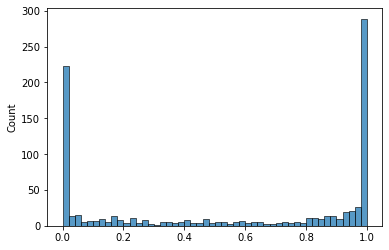

In [13]:
sns.histplot(scores, bins = 50)

In [ ]:
len(scores)

In [97]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += c
    if sum(bin_counts) == 0:
        return (bin_counts, 2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [117]:
scores = []
scores_2 = []
for x in range(500):
    sample = random.sample(full_sample_zero_and_non_zero_mutation_counts, 1000)
    scores.append(mutation_bin_probability(sample)[1])

    bin_counts = [0,0,0]
    for n in range(int(len(sample)/3)):
        temp_counts = [0,0,0]
        for m in range(3): 
            temp_counts[m % 3] = sample[3*n+m]
        if sum(temp_counts) < 10:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    scores_2.append(bin_formula(bin_counts[2], sum(bin_counts)))

##### New CDS

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

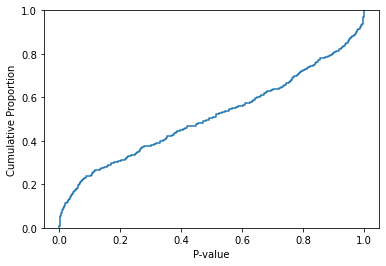

In [118]:
plt = sns.ecdfplot(scores_2)
plt.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')